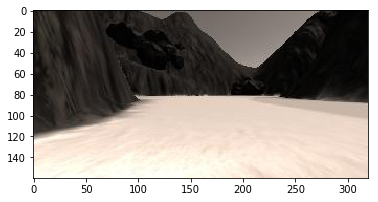

In [1]:
# Import some packages from matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

filename = 'data/sample.jpg'
image = mpimg.imread(filename)

plt.imshow(image)
plt.show()

In [2]:
import numpy as np
print(image.dtype, image.shape, np.min(image), np.max(image))

uint8 (160, 320, 3) 0 255


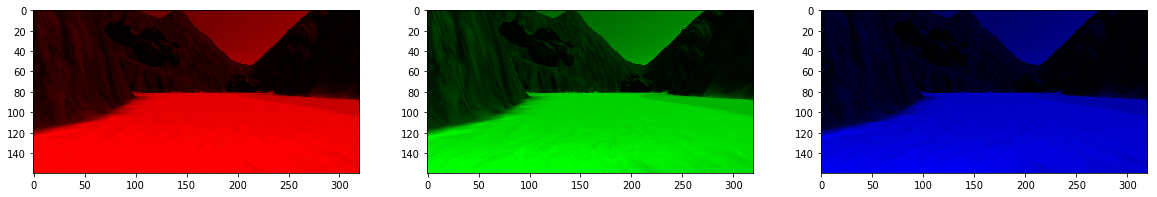

In [3]:
# split to channels
red_channel = np.copy(image)
red_channel[:,:,[1, 2]] = 0 # Zero out the green and blue channels
green_channel = np.copy(image)
green_channel[:,:,[0, 2]] = 0 # Zero out the red and blue channels
blue_channel = np.copy(image)
blue_channel[:,:,[0, 1]] = 0 # Zero out the red and green channels

# display 3 images in one row
fig = plt.figure(figsize=(20,3)) # Create a figure for plotting
plt.subplot(131) # Initialize subplot number 1 in a figure that is 3 columns 1 row
plt.imshow(red_channel) # Plot the red channel
plt.subplot(132) # Initialize subplot number 2 in a figure that is 3 columns 1 row
plt.imshow(green_channel)  # Plot the green channel
plt.subplot(133) # Initialize subplot number 3 in a figure that is 3 columns 1 row
plt.imshow(blue_channel)  # Plot the blue channel
plt.show()

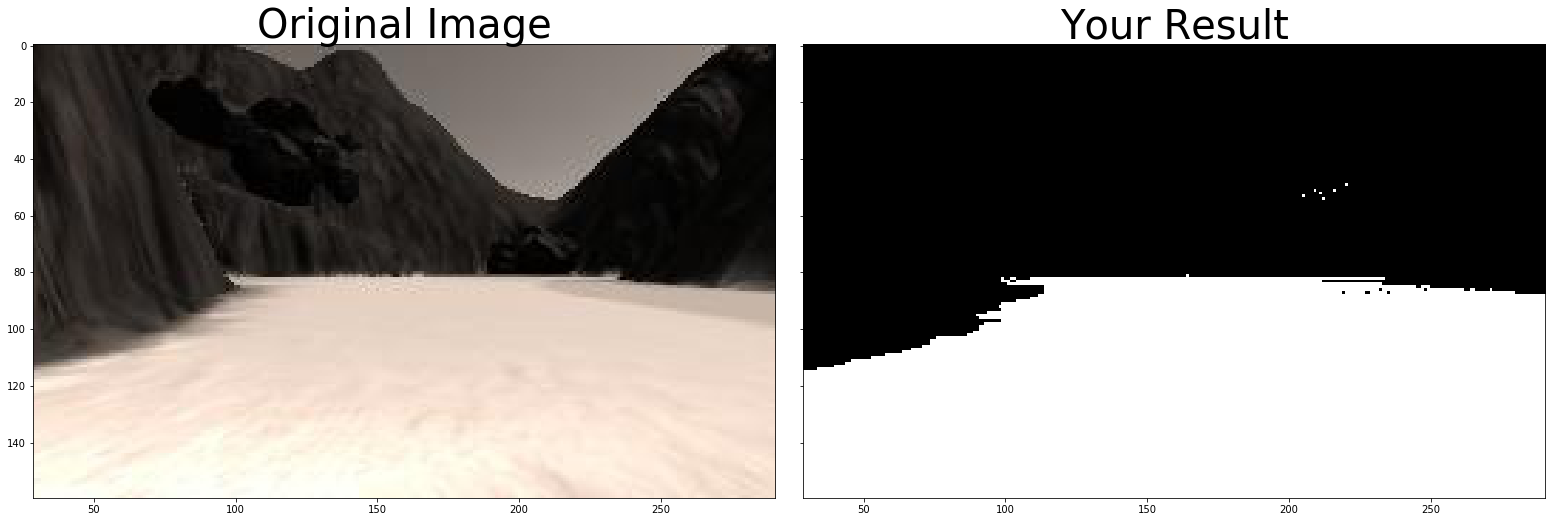

In [4]:
# Define a function to perform a color threshold
def color_thresh(img, rgb_thresh=(0, 0, 0)):
    ###### TODO:
    # Create an empty array the same size in x and y as the image 
    # but just a single channel
    color_select = np.zeros_like(img[:,:,0])
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
            
    color_select[above_thresh] = 1
    # Apply the thresholds for RGB and assign 1's 
    # where threshold was exceeded
    # Return the single-channel binary image
    return color_select
    
# Define color selection criteria
###### TODO: MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 160
green_threshold = 160
blue_threshold = 160
######
rgb_threshold = (red_threshold, green_threshold, blue_threshold)

# pixels below the thresholds
colorsel = color_thresh(image, rgb_thresh=rgb_threshold)

# Display the original image and binary               
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 7), sharey=True)
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(colorsel, cmap='gray')
ax2.set_title('Your Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# Perspective transform

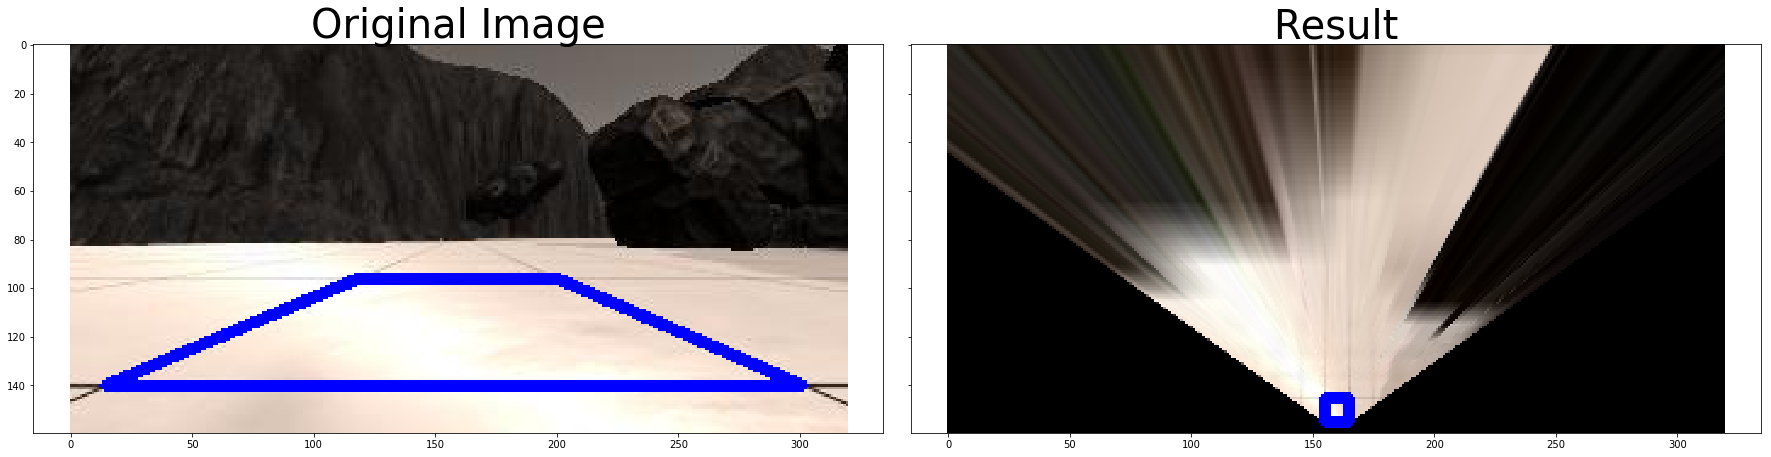

In [5]:
import cv2

image = mpimg.imread('data/example_grid1.jpg')

def perspect_transform(img, src, dst):

    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the result
    return warped


source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
dest_half_size = 5
dest_size = dest_half_size * 2
dest_center_x = image.shape[1] / 2
dest_start_y = image.shape[0] - 5

destination = np.float32([[dest_center_x - dest_half_size, dest_start_y], 
                 [dest_center_x + dest_half_size, dest_start_y], 
                 [dest_center_x + dest_half_size, dest_start_y - dest_size], 
                 [dest_center_x - dest_half_size, dest_start_y - dest_size]])

warped = perspect_transform(image, source, destination)
# Draw Source and destination points on images (in blue) before plotting
cv2.polylines(image, np.int32([source]), True, (0, 0, 255), 3)
cv2.polylines(warped, np.int32([destination]), True, (0, 0, 255), 3)
# Display the original image and binary               
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() # Uncomment if running on your local machine

# Warp, Threshold, and Map to Rover-Centric Coordinates

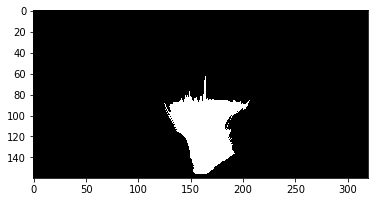

In [6]:
image = mpimg.imread('data/sample.jpg')

warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))

# Plot the result
plt.imshow(colorsel, cmap='gray')
plt.show()

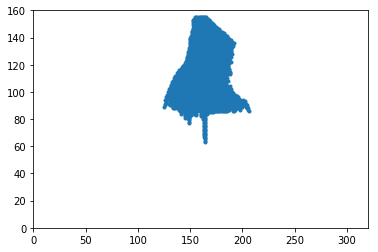

In [7]:
ypos, xpos = colorsel.nonzero()
plt.plot(xpos, ypos, '.')
plt.xlim(0, 320)
plt.ylim(0, 160)
plt.show()

[ 97.  96.  95. ...,   5.   5.   5.] [-4. -4. -4. ..., -3. -4. -5.]


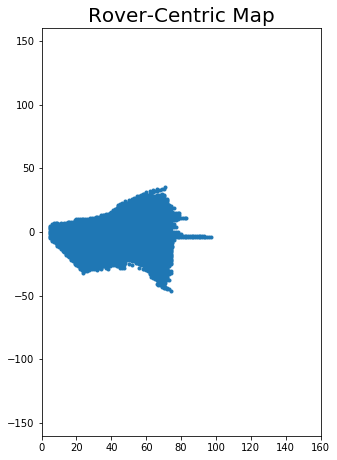

In [8]:
def rover_coords(binary_img):
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2).astype(np.float)
    print(x_pixel, y_pixel)
    return x_pixel, y_pixel

# Perform warping and color thresholding
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))

# Extract x and y positions of navigable terrain pixels
# and convert to rover coordinates
xpix, ypix = rover_coords(colorsel)

# Plot the map in rover-centric coords
fig = plt.figure(figsize=(5, 7.5))
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
plt.title('Rover-Centric Map', fontsize=20)
plt.show() # Uncomment if running on your local machine

# Map to world coordinates

[ 98.  97.  96. ...,   6.   6.   6.] [-4. -4. -4. ..., -3. -4. -5.]
Xpos = [ 114.41772323] Ypos = [ 85.98213758] Yaw = [ 252.00119337]


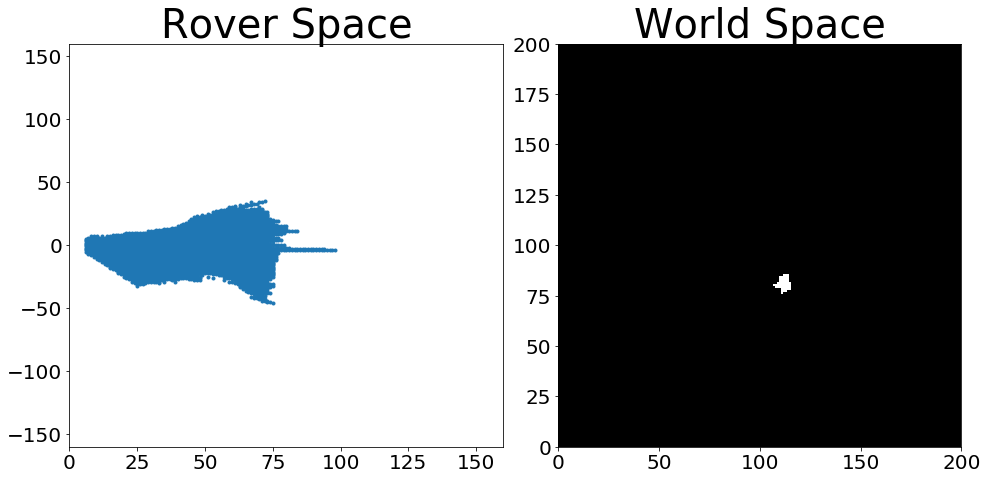

In [9]:
# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: you need to convert this to radians
    # before adding to pixel_angles
rover_yaw = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

# Note: Since we've chosen random numbers for yaw and position, 
# multiple run of the code will result in different outputs each time.

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    yaw_rad = yaw * np.pi / 180
    x_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    y_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)
    return x_rotated, y_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    scale = 10
    # Perform translation and convert to integer since pixel values can't be float
    x_translated = xpos + (xpix_rot / scale)
    y_translated = ypos + (ypix_rot / scale)
    # Return the result  
    return x_translated, y_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# No need to modify code below here
# Perform warping and color thresholding
##########
# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))
# Extract navigable terrain pixels
xpix, ypix = rover_coords(colorsel)
# Generate 200 x 200 pixel worldmap
worldmap = np.zeros((200, 200))
scale = 10
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                worldmap.shape[0], scale)
# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1
print('Xpos =', rover_xpos, 'Ypos =', rover_ypos, 'Yaw =', rover_yaw)
# Plot the map in rover-centric coords

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=40)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(worldmap, cmap='gray')
ax2.set_title('World Space', fontsize=40)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)


plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)
plt.show() # Uncomment if running on your local machine

# Decision: Where to Go?

[ 160.  160.  160. ...,    6.    6.    6.] [ 160.  159.  158. ...,   -0.   -1.   -2.]


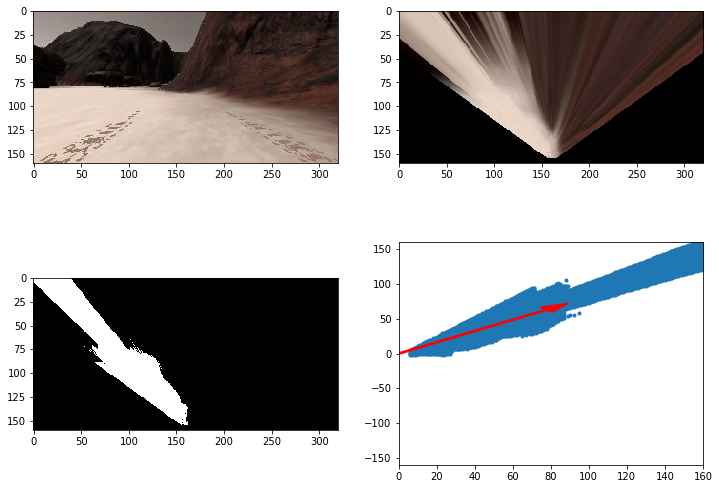

In [12]:
def to_polar_coords(xpix, ypix):
    # Calculate distance to each pixel
    dist = np.sqrt(xpix**2 + ypix**2)
    # Calculate angle using arctangent function
    angles = np.arctan2(ypix, xpix)
    return dist, angles

image = mpimg.imread('data/angle_example.jpg')
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160)) # Threshold the warped image
xpix, ypix = rover_coords(colorsel)  # Convert to rover-centric coords
distances, angles = to_polar_coords(xpix, ypix) # Convert to polar coords
avg_angle = np.mean(angles) # Compute the average angle

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(colorsel, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(avg_angle)
y_arrow = arrow_length * np.sin(avg_angle)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.show()

# More Decisions

In [13]:
class RoverState():
    def __init__(self):
        self.start_time = None # To record the start time of navigation
        self.total_time = None # To record total duration of naviagation
        self.img = None # Current camera image
        self.pos = None # Current position (x, y)
        self.yaw = None # Current yaw angle
        self.pitch = None # Current pitch angle
        self.roll = None # Current roll angle
        self.vel = None # Current velocity
        self.steer = 0 # Current steering angle
        self.throttle = 0 # Current throttle value
        self.brake = 0 # Current brake value
        self.nav_angles = None # Angles of navigable terrain pixels
        self.nav_dists = None # Distances of navigable terrain pixels
        self.ground_truth = ground_truth_3d # Ground truth worldmap
        self.mode = 'forward' # Current mode (can be forward or stop)
        self.throttle_set = 0.2 # Throttle setting when accelerating
        self.brake_set = 10 # Brake setting when braking
        # The stop_forward and go_forward fields below represent total count
        # of navigable terrain pixels.  This is a very crude form of knowing
        # when you can keep going and when you should stop.  Feel free to
        # get creative in adding new fields or modifying these!
        self.stop_forward = 50 # Threshold to initiate stopping
        self.go_forward = 500 # Threshold to go forward again
        self.max_vel = 2 # Maximum velocity (meters/second)
        # Image output from perception step
        # Update this image to display your intermediate analysis steps
        # on screen in autonomous mode
        self.vision_image = np.zeros((160, 320, 3), dtype=np.float) 
        # Worldmap
        # Update this image with the positions of navigable terrain
        # obstacles and rock samples
        self.worldmap = np.zeros((200, 200, 3), dtype=np.float) 
        self.samples_pos = None # To store the actual sample positions
        self.samples_found = 0 # To count the number of samples found
        self.near_sample = False # Set to True if within reach of a rock sample
        self.pick_up = False # Set to True to trigger rock pickup

# Take Action!

In [14]:
def send_control(commands, image_string1, image_string2):
    # Define commands to be sent to the rover
    data={
        'throttle': commands[0].__str__(),
        'brake': commands[1].__str__(),
        'steering_angle': commands[2].__str__(),
        'inset_image1': image_string1,
        'inset_image2': image_string2,
        }
    # Send commands via socketIO server
    sio.emit(
        "data",
        data,
        skip_sid=True)